# Kmeans Clustering

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('default')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Constants and Functions

In [44]:
NUMB_SAMPLES=150
K_CLUSTERS = 3

colors = ['#bc9eeb', '#8EE35D', '#E37346']
colors_centroids = ['#9f74e3', '#b0eb8e', '#eb9d7e']

import random
def get_random_centroids(X,k):
    '''
    chooses k centroids randomly chosen from
    the number of points in X
    '''
    samps=random.sample(range(0, NUMB_SAMPLES-1), k)
    c=X.iloc[samps,:].copy()
    c.reset_index(drop=True, inplace=True)  #get rid of original random integer index
    c.reset_index( inplace=True)  #quick way to get 0,1,2
    c.rename(columns={'index':'cluster_number'}, inplace=True)
    c.drop(columns=['cluster_guess'], axis=1,inplace=True)
    return c
    # centroids=[]
    # for i in range(k):
    #     r=random.randint(0, NUMB_SAMPLES)
    #     centroids.append([X[r,0],X[r,1],i])
    # return np.array(centroids)

# used for custom color palette below
colors1 = {-1:"tab:brown",
            0:"tab:cyan",
           1:"tab:orange", 
           2:"tab:purple"}

## Generate some data 
generate a synthetic dataset using sklearns makeblobs , see <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html">Make Blobs</a>

In [3]:
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs

In [66]:
# Generate sample data
#note that y denotes group membership, something we are trying to predict
X,_=make_blobs(n_samples=NUMB_SAMPLES,
              n_features=2,
              centers=K_CLUSTERS+3,
              cluster_std=0.5,
              shuffle=True,
              random_state=0)

#place in DataFrame
X=pd.DataFrame(data=X, columns=["X0","X1"])
X['cluster_guess']=-1

# K means, General Algorithm
<ol>
    <li>Randomly pick *k* centroids from sample points as initial cluster centers</li>
    <li>Assign each sample to the nearest centroid</li>
    <li>Move the centroids to the center of the samples assigned to it</li>
    <li>Repeat steps 2 and 3 until cluster membership stops changing</li>
</ol>

## Randomly pick *k* centroids from sample points as initial cluster centers

In [68]:
#get the centroids
centroids=get_random_centroids(X,K_CLUSTERS)
# centroids.head()

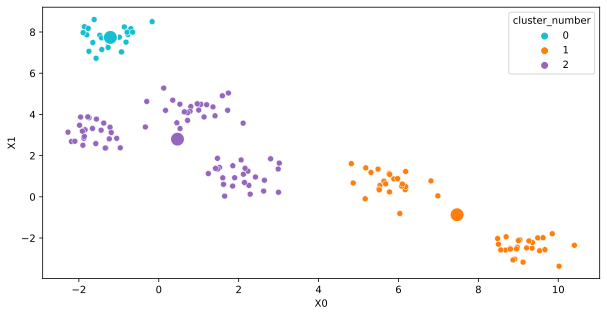

In [81]:
#lets see our random centroids and data
fig = plt.figure(figsize=(10,5));
sns.scatterplot(data=X,x="X0",y="X1",hue='cluster_guess', legend=False, palette=colors1);
sns.scatterplot(data=centroids,x="X0",y="X1",s =200,hue='cluster_number', palette=colors1);

## Assign each sample to the nearest centroid then move the centrods to the mean of their assigned clusters

In [80]:
import math
def find_closest_cluster(df, centroids):
    # which cluster is this point closest to
    dsts = []  
    for _,c in centroids.iterrows():
        dsts.append(math.dist( (df[0],df[1]),(c[1],c[2])))

    #which centroid
    return (dsts.index(min(dsts)))

def find_mean(df):
    #find the mean
    return df.mean()

old=X['cluster_guess'].copy()
X['cluster_guess']=X.apply(find_closest_cluster, centroids=centroids, axis=1)  #assign points to a cluster
print(f'{sum(old!=X.cluster_guess)} points changed clusters')


new_centroid_center = X.groupby('cluster_guess').apply(find_mean)   #get new cluster mean
centroids['X0']=new_centroid_center['X0']
centroids['X1']=new_centroid_center['X1']

0 points changed clusters


## Repeat the above 2 sections until no other points change clusters

# Now lets use sklearns implementation to do the same